# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2023-2024, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Maria de Neves de Fonseca (M.deNevesdeFonseca-1@student.tudelft.nl)
* (c) TU Delft, 2024

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Zhengyang Lu"
STUDENT_1_STUDENT_NUMBER = "5074428"
STUDENT_1_NETID = "zhengyanglu"
STUDENT_1_EMAIL = "Z.lu-5@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 2c.1 - Collect dataset (2p)

**Author:** Maximilian Stölzle (M.W.Stolzle@tudelft.nl)

Before we can learn the dynamics of the system, we need to collect a dataset. We do that by sampling evolutions of the double pendulum system. The final dataset will be saved in the path `datasets/dataset_double_pendulum.npz`. A well-distributed and sufficiently large dataset is a necessary pre-condition for successfully training the Lagrangian neural network in the following tasks.

In [3]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2
# for creating a responsive plot
%matplotlib widget

# import all Python modules
from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
from jax import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import Array, jit, lax, random
from jax import numpy as jnp
from matplotlib import rcParams
import matplotlib.pyplot as plt
import os
from pathlib import Path
from progressbar import progressbar
from typing import Dict, Tuple

from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.visualization import animate_robot

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))
# define tolerances for grading
RTOL = float(os.environ.get("RTOL", "1e-4"))  # relative tolerance
ATOL = float(os.environ.get("ATOL", "1e-7"))  # absolute tolerance

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Sampling of system evolutions

Please implement the function `sample_system_evolution`. It should include the following steps:

1. Splitting the random keys as explained in the [JAX documentation](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html).

2. Randomly sample the initial conditions for the simulation.

3. Run the simulation for the timesteps specified in `t_ts`.

In [4]:
@jit
def sample_system_evolution(
    rng: Array,
    rp: Dict,
    t_ts: Array,
    max_th_d_0: Array,
    max_tau_ts: Array,
) -> Tuple[Dict[str, Array], Array]:
    """
    Samples a system evolution from the robot simulation.
    Args:
        rp: Dictionary with robot parameters
        t_ts: time steps of the trajectory [s] of shape (num_time_steps, )
        rng: PRNG key
        max_th_d_0: array of shape (2, ) with maximum magnitude of initial link angular velocities
        max_tau_ts: array of shape (N, 2) with maximum magnitude of torque applied to system
    Returns:
        sim_ts: Dictionary containing the time series of system states.
        rng_updated: updated PRNG key
    """
    # split the PRNG key into four new keys
    # one of the new keys should be saved in the `rng_updated` variable and be returned
    # the other three keys can be used for sampling random values
    rng_updated, rng_subkey1, rng_subkey2, rng_subkey3 = None, None, None, None
    # YOUR CODE HERE
    rng_updated, rng_subkey1, rng_subkey2, rng_subkey3 = random.split(rng, num=4)

    # randomly sample the initial conditions of the simulation
    # the initial link angle `th_0`
    # the initial link angular velocity `th_d_0`
    # the torque sequence of shape (N, 2) applied to the system
    th_0, th_d_0 = jnp.zeros((2,)), jnp.zeros((2,))
    tau_ts = jnp.zeros((t_ts.shape[0], 2))

    # YOUR CODE HERE
    th_0 = random.uniform(rng_subkey1, shape=(2,), minval=-jnp.pi, maxval=jnp.pi)
    th_d_0 = random.uniform(rng_subkey2, shape=(2, ), minval=-max_th_d_0, maxval=max_th_d_0)
    tau_ts = random.uniform(rng_subkey3, shape=(t_ts.shape[0], 2), minval=-max_tau_ts, maxval=max_tau_ts)

    # simulate the robot for the timestamps `t_ts`
    sim_ts = None
    # YOUR CODE HERE
    sim_ts = simulate_robot(
        rp=rp,
        t_ts=t_ts,
        th_0=th_0,
        th_d_0=th_d_0,
        tau_ext_ts=tau_ts
    )

    return sim_ts, rng_updated

## Save simulation data into dataset

The previous function has sampled system evolutions and saved them into `sim_ts`. Now, we need to post-process the simulation data to generate a dataset of the discrete-time system states. This namely includes the link angles $\theta(k) \in \mathbb{R}^2$ and link velocities $\dot{\theta}(k) \in \mathbb{R}^2$ at the current time-step $k$ and the corresponding states at the next time-step $\theta(k+1)$ and $\dot{\theta}(k+1)$. It also includes the torques $\tau(k)$ applied to the system.

In [5]:
@jit
def save_sim_data_to_dataset(
    dataset: Dict[str, Array], sim_idx: int, sim_ts: Dict[str, Array]
) -> Dict[str, Array]:
    """
    Saves the data of one simulation to the dataset.
    Args:
        dataset: Dictionary of arrays containing the dataset.
        sim_idx: Index of the simulation.
        sim_ts: Dictionary containing the time series of system states for the simulation

    Returns:
        dataset: Dictionary of arrays containing the dataset (updated).
    """
    # number of timesteps
    N = sim_ts["t_ts"].shape[0]

    # the starting index in dataset we save the data to
    start_idx = sim_idx * (N - 1)

    # please define the arrays we can save into the dataset
    # store the applied torques as array of shape (N - 1, 2)
    tau_ss = jnp.zeros((N - 1, sim_ts["tau_ts"].shape[-1]))
    # store the current link angles as array of shape (N - 1, 2)
    th_curr_ss = jnp.zeros((N - 1, sim_ts["th_ts"].shape[-1]))
    # store the current link angular velocities as array of shape (N - 1, 2)
    th_d_curr_ss = jnp.zeros((N - 1, sim_ts["th_d_ts"].shape[-1]))
    # store the next link angles as array of shape (N - 1, 2)
    th_next_ss = jnp.zeros((N - 1, sim_ts["th_ts"].shape[-1]))
    # store the next link angular velocities as array of shape (N - 1, 2)
    th_d_next_ss = jnp.zeros((N - 1, sim_ts["th_d_ts"].shape[-1]))
    # YOUR CODE HERE
    tau_ss = sim_ts["tau_ts"][:N-1]
    th_curr_ss = sim_ts["th_ts"][:N-1]
    th_d_curr_ss = sim_ts["th_d_ts"][:N-1]
    th_next_ss = sim_ts["th_ts"][1:N]
    th_d_next_ss = sim_ts["th_d_ts"][1:N]

    dataset["tau_ss"] = lax.dynamic_update_slice(
        dataset["tau_ss"], tau_ss, (start_idx, 0)
    )
    dataset["th_curr_ss"] = lax.dynamic_update_slice(
        dataset["th_curr_ss"], th_curr_ss, (start_idx, 0)
    )
    dataset["th_d_curr_ss"] = lax.dynamic_update_slice(
        dataset["th_d_curr_ss"], th_d_curr_ss, (start_idx, 0)
    )
    dataset["th_next_ss"] = lax.dynamic_update_slice(
        dataset["th_next_ss"], th_next_ss, (start_idx, 0)
    )
    dataset["th_d_next_ss"] = lax.dynamic_update_slice(
        dataset["th_d_next_ss"], th_d_next_ss, (start_idx, 0)
    )

    return dataset

## Execute the dataset collection

Below, you need to choose the parameters for the dataset collection. This specifically includes:

- The number of simulations you want to run `num_simulations`
- The duration of each simulation `sim_duration`
- And finally the maximum magnitude of the initial link angular velocity, which is used during the sampling of the initial conditions in `sample_system_evolution()`.

In [6]:
# initialize random number generator with seed = 0
rng = random.PRNGKey(seed=0)

# simulation parameters
# please carefully choose the parameters for the dataset collection
# In particular, consider adjusting `num_simulations`, `sim_duration`, `max_th_d_0`, and `max_tau_ts`

# time step [s]. Helps to determine the number of samples in advance.
sim_dt = 1e-2
# number of times we call the `sample_system_evolution` method
num_simulations = 10
# duration of each simulation [s]. Helps to determine the number of samples in advance.
sim_duration = 10.0
# YOUR CODE HERE


# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# maximum magnitude of initial link angular velocity [rad / s]. Used for sampling initial condition
max_th_d_0 = jnp.pi/100 * jnp.ones((2,))
# maximum magnitude of torque [Nm] applied to system.
max_tau_ts = 0.1 * jnp.ones((t_ts.shape[0], 2))
# YOUR CODE HERE
# max_tau_ts = 100 * jnp.ones((t_ts.shape[0], 2))
# option to animate the robot
ANIMATE_ROBOT = False

In [7]:
# folder to save plots to
outputs_dir = Path("outputs")
outputs_dir.mkdir(exist_ok=True, parents=True)

# folder to save the dataset to
dataset_folder = Path("datasets")
dataset_folder.mkdir(exist_ok=True, parents=True)

# determine the total number of samples we expect to collect
num_dataset_samples = num_simulations * (t_ts.shape[0] - 1)

print(
    f"Collecting dataset by running {num_simulations} simulations each for a duration of {sim_duration}s"
    f"generating in total {num_dataset_samples} samples ..."
)

# initialize empty arrays for storing the dataset samples
dataset = {
    "dt_ss": sim_dt * jnp.ones(num_dataset_samples),
    "tau_ss": jnp.zeros((num_dataset_samples, 2)),
    "th_curr_ss": jnp.zeros((num_dataset_samples, 2)),
    "th_d_curr_ss": jnp.zeros((num_dataset_samples, 2)),
    "th_next_ss": jnp.zeros((num_dataset_samples, 2)),
    "th_d_next_ss": jnp.zeros((num_dataset_samples, 2)),
}

In [8]:
for sim_idx in progressbar(range(num_simulations)):
    # sample the system evolution and update the PRNG key
    # save the simulation data to the `sim_ts` variable and the new PRNG key to the `rng` variable
    # YOUR CODE HERE
    sim_ts, rng = sample_system_evolution(rng, ROBOT_PARAMS, t_ts, max_th_d_0, max_tau_ts)

    # save the simulation data from the last simulation to the `dataset` variable
    # YOUR CODE HERE
    dataset = save_sim_data_to_dataset(dataset, sim_idx, sim_ts)

    if ANIMATE_ROBOT:
        animate_robot(
            ROBOT_PARAMS,
            sim_ts=sim_ts,
            step_skip=5,
            filepath=str(
                outputs_dir / f"task_2c-1_training_set_animation_{sim_idx}.mp4"
            ),
        )

# save the dataset in problem_2/datasets/dataset_double_pendulum_dynamics.npz
jnp.savez(file=str(dataset_folder / "dataset_double_pendulum_dynamics.npz"), **dataset)

  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


 10% (1 of 10) |##                       | Elapsed Time: 0:00:02 ETA:   0:00:22
100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


## Visualizing the dataset distribution

First, we provide you with a function to visualize the dataset distribution on polar plots (for each link). Here, $\theta$ is represented by the polar angles and the radial axis is used to denote $\dot{\theta}$. The coloring indicates the angular acceleration $\ddot{\theta}$ of the links.

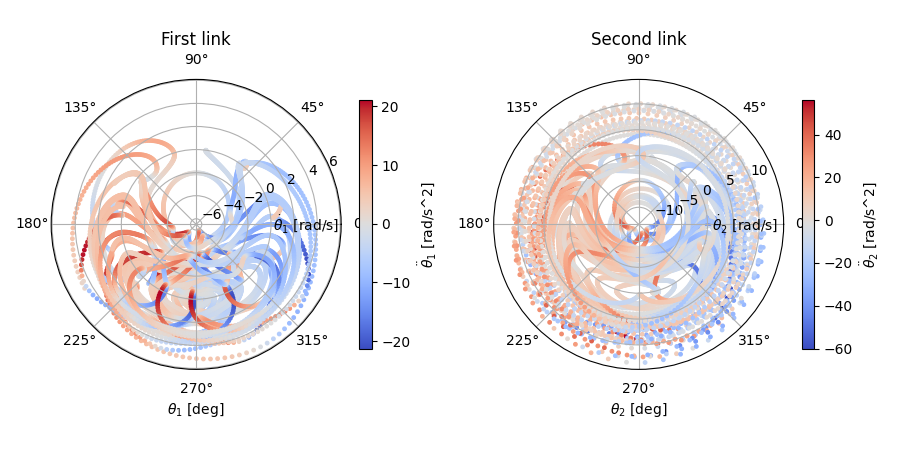

In [9]:
from lnn_analysis import plot_dataset_state_distribution_polar_scatter

# we plot the distribution of the dataset using two polar scatter plots
if not AUTOGRADING:
    plot_dataset_state_distribution_polar_scatter(
        sim_dt,
        dataset,
        filepath=str(
            outputs_dir / "task_2c-1_dataset_state_distribution_polar_scatter.pdf"
        ),
    )

Next, we plot the trajectories included in the dataset on a torus, where the larger radius represents $\theta_1$ (i.e., the angle of the first link) and the smaller radius denotes $\theta_2$ (i.e., the angle of the second link). The color denotes the Euclidean norm of the configuration-space velocity at the given configuration.

  0%|          | 0/10 [00:00<?, ?it/s]

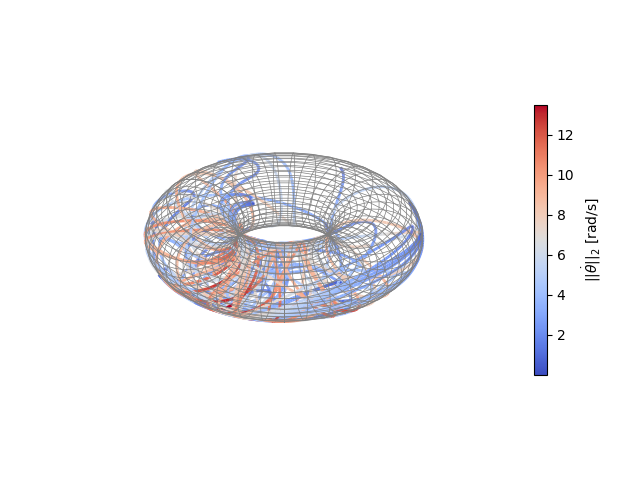

In [10]:
from lnn_analysis import plot_dataset_state_distribution_torus

# we plot the distribution of the dataset using a torus plot
if not AUTOGRADING:
    plot_dataset_state_distribution_torus(
        num_simulations,
        dataset,
        filepath=str(outputs_dir / "task_2c-1_dataset_state_distribution_torus.pdf"),
    )

## Analysis of the distribution of generalized torques (2p)

We must appropriately choose the dataset collection hyperparameters to achieve a good fit of the LNN parameters (not just on the training set but also for the workspace where we want to use the LNN for dynamical predictions). This section will specifically analyze the generalized torques acting on $\theta$ for the collected dataset. 

First, we plot the distribution of the $\ell_2$ norm of the generalized torques acting on the robot $\lVert \tau_\star \rVert_2$ with a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) where we separate the contribution of the external torques $\tau$, the gravitational forces $G(\theta)$, and the Coriolis forces $C(\theta,\dot{\theta}) \, \dot{\theta}$. We note that these computed torques are based on our first-principle model of the robot and that except for the external torques, we would in practice not have access to these quantities before training the LNN.

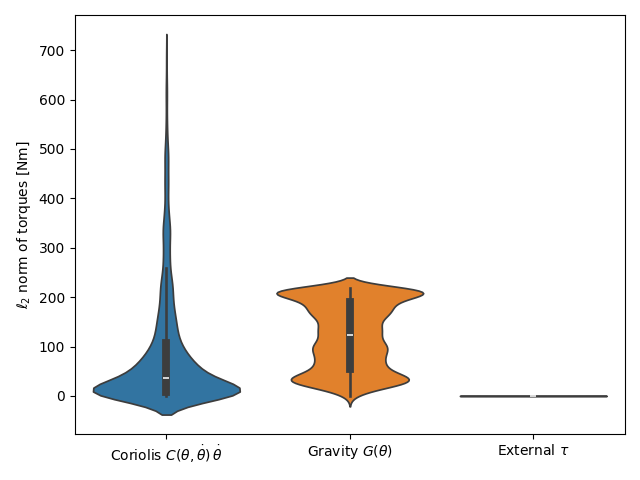

In [11]:
from lnn_analysis import plot_dataset_generalized_torque_distribution_violin

plot_dataset_generalized_torque_distribution_violin(
    ROBOT_PARAMS,
    dataset,
    filepath=str(
        outputs_dir / "task_2c-1_dataset_generalized_torque_distribution_violin.pdf"
    ),
)

### LNN training without external torques (1p)

Let's assume we collect a dataset with zero (or near zero) external torques (i.e., $|\tau| \sim 0$). What would be the effect on the LNN training compared to when applying external torques with a similar order of magnitude as the gravitional forces (i.e., $|\tau| \sim |G(\theta)|$)?

**A.** Improved dynamical prediction performance as the system moves more slowly.

**B.** The learning algorithm is not able to distinguish between the contribution of the potential forces and the inertia of the system.

**C.** The mass matrix would still be learned accuratly, but the Coriolis and Centrifugal effects are neglected.

**D.** No effect. 

In [ ]:
# please write the answer ("A", "B", "C", or "D") into the `answer_1` variable
answer_1 = None

# YOUR CODE HERE
answer_1 = "C"

In [ ]:
# DO NOT REMOVE OR MODIFY THIS CELL
assert answer_1 in ["A", "B", "C", "D"], 'Please answer "A", "B", "C", or "D"'


### LNN training with very large external torques (1p)

Let's assume we collect a dataset with the external torques being significantly larger than the potential forces (i.e., $|\tau| \gg |G(\theta)|$). What would be the effect on the LNN training compared to when applying external torques with a similar order of magnitude as the gravitional forces (i.e., $|\tau| \sim |G(\theta)|$)?

**A.** Large external torques lead to large $|\dot{\theta}|$, therefore allowing us to learn the Coriolis matrix $C(\theta,\dot{\theta})$ very accurately.

**B.** The dynamical predictor would not be able to generalize to situations when zero external torques are applied.

**C.** The potential would not be learned accurately as it can be neglected when rolling out the dynamics.

**D.** No effect.

In [ ]:
# please write the answer ("A", "B", "C", or "D") into the `answer_2` variable
answer_2 = None

# YOUR CODE HERE
answer_2 = "C"

In [ ]:
# DO NOT REMOVE OR MODIFY THIS CELL
assert answer_2 in ["A", "B", "C", "D"], 'Please answer "A", "B", "C", or "D"'
